<a href="https://colab.research.google.com/github/squeeko/TensorflowProjects/blob/in_progress/TF_PreProcess_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load images

This tutorial shows how to load and preprocess an image dataset in three ways. First, you will use high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) to read a directory of images on disk. Next, you will write your own input pipeline from scratch using [tf.data](https://www.tensorflow.org/guide/data). Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in TensorFlow [Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tdfs

In [2]:
print(tf.__version__)

2.3.0


## Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

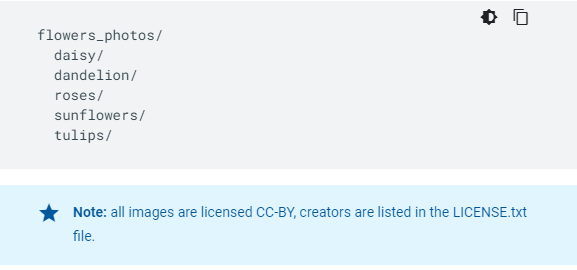

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir) 

228818944/228813984 [==============================] - 3s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

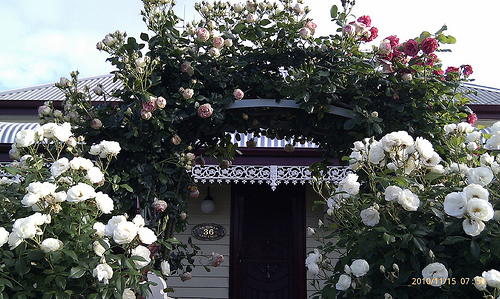

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

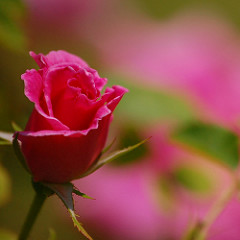

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load using keras.preprocessing

Let's load these images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

## Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

NOTE: subset = "training" or "validation" is how it determines the split for the datasets. Also the "validation_split = 0.2", in both subsets is needed to tell how to split, in this case 80/20

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets.

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

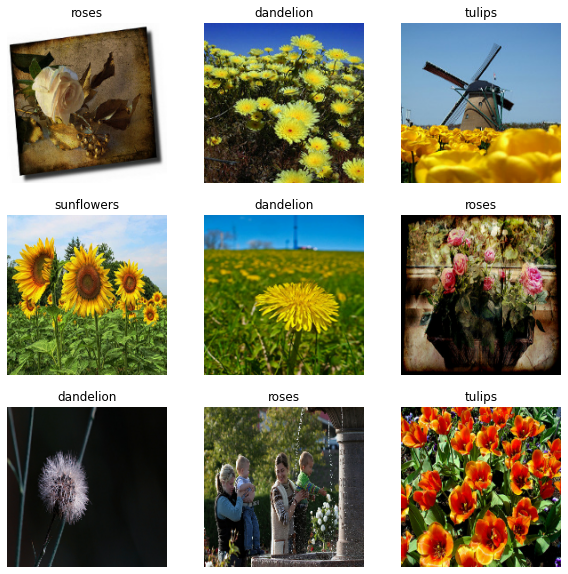

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Note: you can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [13]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print("Minimum pixel value", np.min(first_image), "\nMaximum pixel value", np.max(first_image))

Minimum pixel value 0.0 
Maximum pixel value 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

Note: If you would like to scale pixel values to [-1,1] you can instead write Rescaling(1./127.5, offset=-1)

Note: we previously resized images using the image_size argument of image_dataset_from_directory. If you want to include the resizing logic in your model, you can use the Resizing layer instead.

##Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Train a model
For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this [tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [16]:
num_classes = 5

model = tf.keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
])

In [17]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Note: we will only train for a few epochs so this tutorial runs quickly.

In [18]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 8s 84ms/step - loss: 1.3394 - accuracy: 0.4292 - val_loss: 1.1401 - val_accuracy: 0.5191
Epoch 2/3
92/92 [==============================] - 2s 22ms/step - loss: 1.0967 - accuracy: 0.5535 - val_loss: 1.0425 - val_accuracy: 0.5995
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.9685 - accuracy: 0.6270 - val_loss: 0.9468 - val_accuracy: 0.6362


Note: you can also write a custom training loop instead of using model.fit. To learn more, visit this [tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

You may notice the validation accuracy is low to the compared to the training accuracy, indicating our model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control
The above keras.preprocessing utilities are a convenient way to create a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from a directory of images. For finer grain control, you can write your own input pipeline using [tf.data](https://www.tensorflow.org/api_docs/python/tf/data). This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/15549402199_2890918ddb.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/2443095419_17b920d155_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3861452393_14d2f95157_m.jpg'
b'/root/.keras/datasets/flower_photos/roses/4558025386_2c47314528.jpg'
b'/root/.keras/datasets/flower_photos/daisy/4482623536_b9fb5ae41f_n.jpg'


In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size) # grabs the 80%, skip 20%
val_ds = list_ds.take(val_size) # takes the remaining 20%

You can see the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734
